In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=18
currency_pair = 'USD=X'
numbers_in_currency = 'USD'
share_name = 'IAC'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2005-12-31,1691,-871,820,120,987,427,336,4170,7222,...,13918,574,0,375,2233,959,4687,383,-41,356.618
1,2006-03-31,1353,-677,677,45,1086,509,343,3928,7341,...,13744,591,0,378,2144,882,4471,109,-59,319.535
2,2006-06-30,1432,-719,713,57,1061,486,365,3657,7352,...,13430,659,0,371,2202,858,4506,261,-51,319.535
3,2006-09-30,1404,-706,698,64,1069,546,426,3463,7259,...,13171,666,0,344,2142,872,4435,142,-54,319.535
4,2006-12-31,1720,-879,841,-2,1428,412,326,3959,6850,...,13197,559,0,358,2267,856,4457,315,19,319.535


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
68,2022-12-31,2023-02-11,86.350,1247,-416,830,-13,1417,608,0,...,1170,10394,133,0,30,1080,2020,4462,19,-27
69,2023-03-31,2023-04-21,86.464,1084,-342,743,415,1399,538,0,...,1116,10754,115,0,30,999,2013,4487,25,-22
70,2023-06-30,2023-07-21,86.464,1112,-353,759,-92,1327,522,0,...,1062,10549,128,0,30,1035,2006,4432,103,-86
71,2023-09-30,2023-10-21,86.464,1111,-342,769,-392,1252,519,0,...,1001,10018,144,0,30,1024,2001,4277,14,-19
72,2023-12-31,2024-02-11,86.464,1058,-305,753,327,1297,537,0,...,875,10371,106,0,30,950,1993,4293,47,-15


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
if currency_pair != 'USD=X':
    data['usd_nat_currency'] = utils.daily_price(
        ticker=currency_pair,
        end=data['date'],
        days_earlier=90
        )
else:
    data['usd_nat_currency'] = [1 for x in range(len(data))]

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
68,2022-12-31,2023-02-11,86.350,1247,-416,830,-13,1417,608,0,...,10394,133,0,30,1080,2020,4462,19,-27,1
69,2023-03-31,2023-04-21,86.464,1084,-342,743,415,1399,538,0,...,10754,115,0,30,999,2013,4487,25,-22,1
70,2023-06-30,2023-07-21,86.464,1112,-353,759,-92,1327,522,0,...,10549,128,0,30,1035,2006,4432,103,-86,1
71,2023-09-30,2023-10-21,86.464,1111,-342,769,-392,1252,519,0,...,10018,144,0,30,1024,2001,4277,14,-19,1
72,2023-12-31,2024-02-11,86.464,1058,-305,753,327,1297,537,0,...,10371,106,0,30,950,1993,4293,47,-15,1


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
68,2022-12-31,2023-02-11,86.350,1247.0,-416.0,830.0,-13.0,1417.0,608.0,0.0,...,10394.0,133.0,0.0,30.0,1080.0,2020.0,4462.0,19.0,-27.0,1
69,2023-03-31,2023-04-21,86.464,1084.0,-342.0,743.0,415.0,1399.0,538.0,0.0,...,10754.0,115.0,0.0,30.0,999.0,2013.0,4487.0,25.0,-22.0,1
70,2023-06-30,2023-07-21,86.464,1112.0,-353.0,759.0,-92.0,1327.0,522.0,0.0,...,10549.0,128.0,0.0,30.0,1035.0,2006.0,4432.0,103.0,-86.0,1
71,2023-09-30,2023-10-21,86.464,1111.0,-342.0,769.0,-392.0,1252.0,519.0,0.0,...,10018.0,144.0,0.0,30.0,1024.0,2001.0,4277.0,14.0,-19.0,1
72,2023-12-31,2024-02-11,86.464,1058.0,-305.0,753.0,327.0,1297.0,537.0,0.0,...,10371.0,106.0,0.0,30.0,950.0,1993.0,4293.0,47.0,-15.0,1


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2006-02-13,5.010062,2005-12-31,1691.0,1.345978,25.88484,356.618,1696.0,4.755789,987.0,...,0.663242,0.336758,15.840749,6.069686,6.85309,10.369048,0.48492,0.070964,0.034488,0.051999
1,2006-02-20,5.048846,2005-12-31,1691.0,1.345978,25.88484,356.618,1696.0,4.755789,987.0,...,0.663242,0.336758,15.840749,6.069686,6.85309,10.369048,0.48492,0.070964,0.034488,0.051999
2,2006-02-27,5.286833,2005-12-31,1691.0,1.345978,25.88484,356.618,1696.0,4.755789,987.0,...,0.663242,0.336758,15.840749,6.069686,6.85309,10.369048,0.48492,0.070964,0.034488,0.051999
3,2006-03-06,5.325615,2005-12-31,1691.0,1.345978,25.88484,356.618,1696.0,4.755789,987.0,...,0.663242,0.336758,15.840749,6.069686,6.85309,10.369048,0.48492,0.070964,0.034488,0.051999
4,2006-03-13,5.410233,2005-12-31,1691.0,1.345978,25.88484,356.618,1696.0,4.755789,987.0,...,0.663242,0.336758,15.840749,6.069686,6.85309,10.369048,0.48492,0.070964,0.034488,0.051999


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2006-02-13,5.010062,2005-12-31,1691.0,1.345978,25.88484,356.618,1696.0,4.755789,987.0,...,10.369048,0.48492,0.070964,0.034488,0.051999,3.722246,0.193552,0.264145,0.811159,1.053466
1,2006-02-20,5.048846,2005-12-31,1691.0,1.345978,25.88484,356.618,1696.0,4.755789,987.0,...,10.369048,0.48492,0.070964,0.034488,0.051999,3.751061,0.195050,0.266190,0.813204,1.061621
2,2006-02-27,5.286833,2005-12-31,1691.0,1.345978,25.88484,356.618,1696.0,4.755789,987.0,...,10.369048,0.48492,0.070964,0.034488,0.051999,3.927874,0.204244,0.278737,0.825751,1.111663
3,2006-03-06,5.325615,2005-12-31,1691.0,1.345978,25.88484,356.618,1696.0,4.755789,987.0,...,10.369048,0.48492,0.070964,0.034488,0.051999,3.956688,0.205743,0.280782,0.827796,1.119817
4,2006-03-13,5.410233,2005-12-31,1691.0,1.345978,25.88484,356.618,1696.0,4.755789,987.0,...,10.369048,0.48492,0.070964,0.034488,0.051999,4.019555,0.209012,0.285243,0.832257,1.137610


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

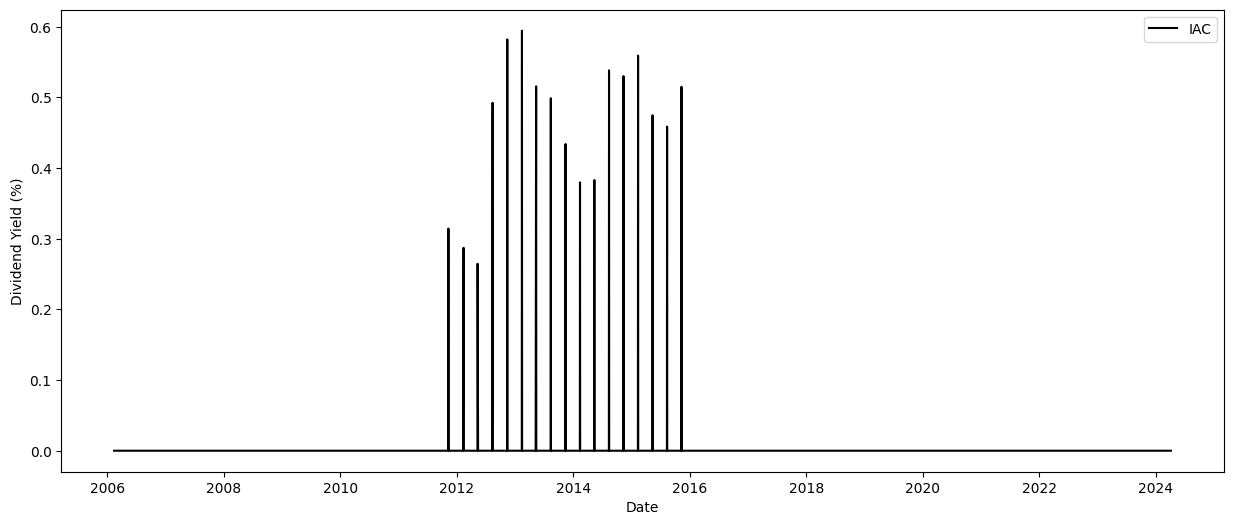

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   NaN
share_price     NaN
Name: share_price, dtype: float64


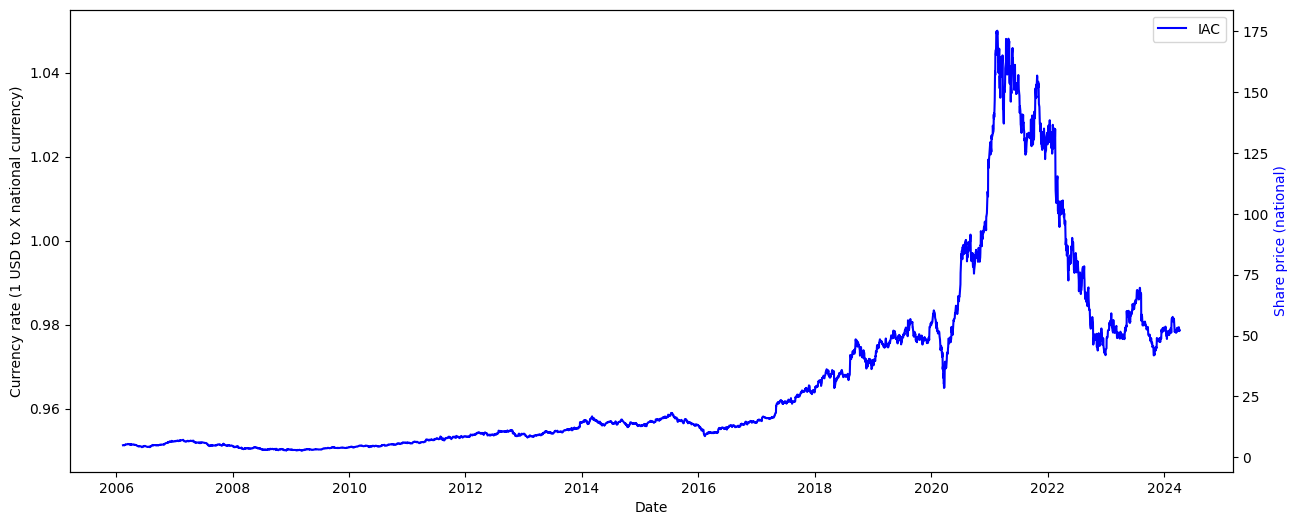

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

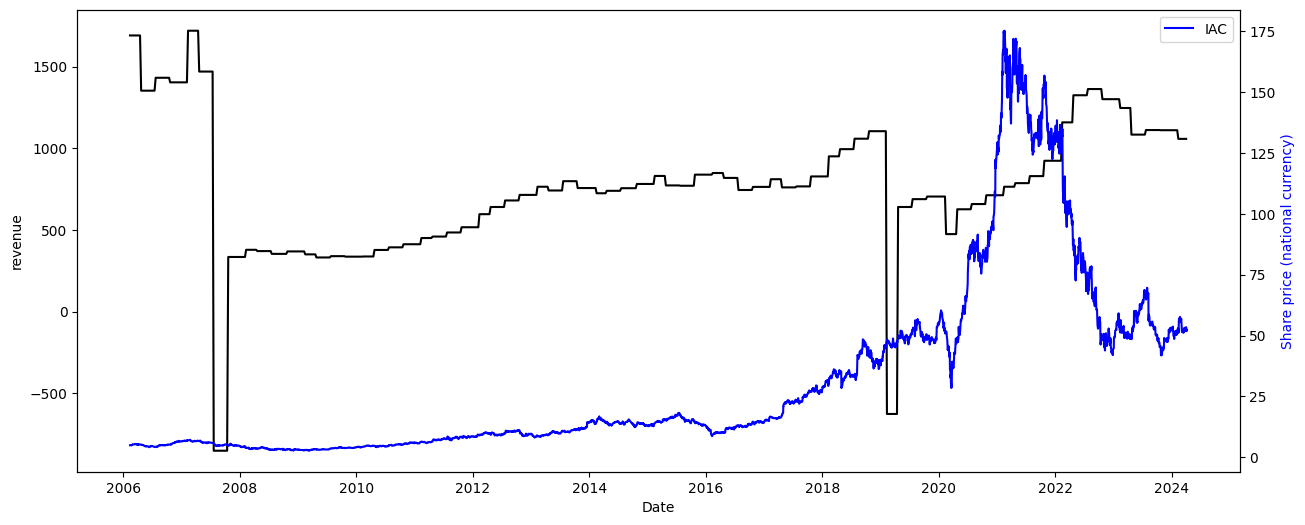

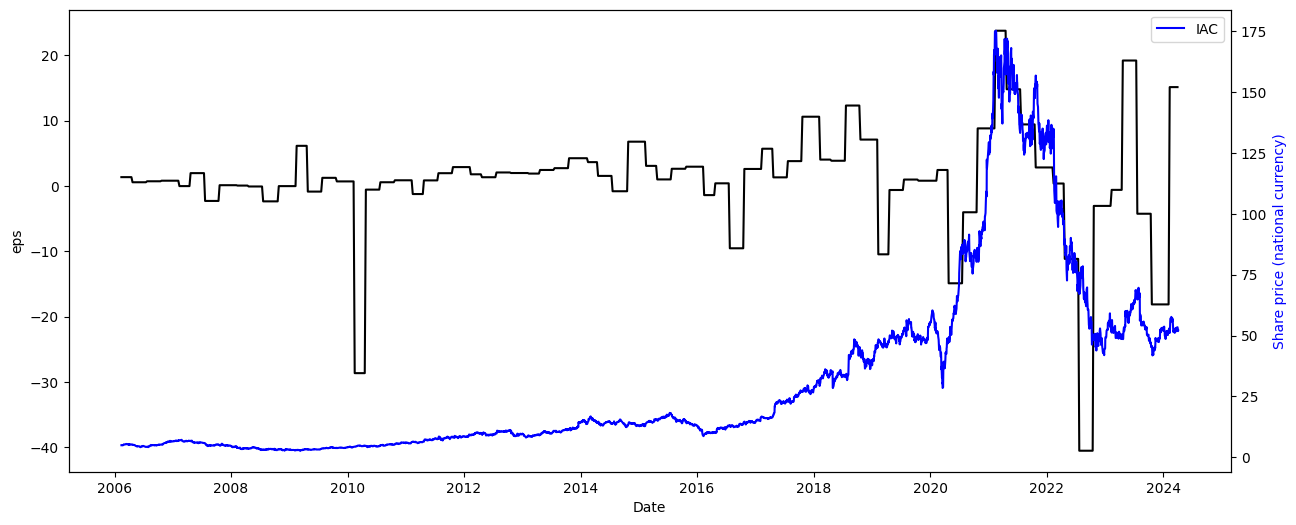

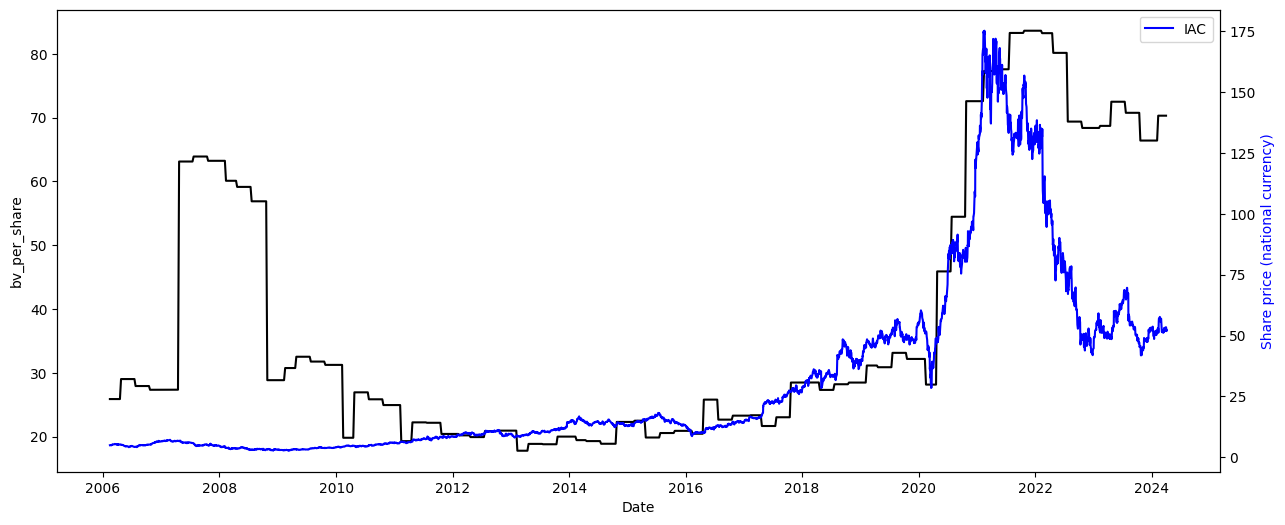

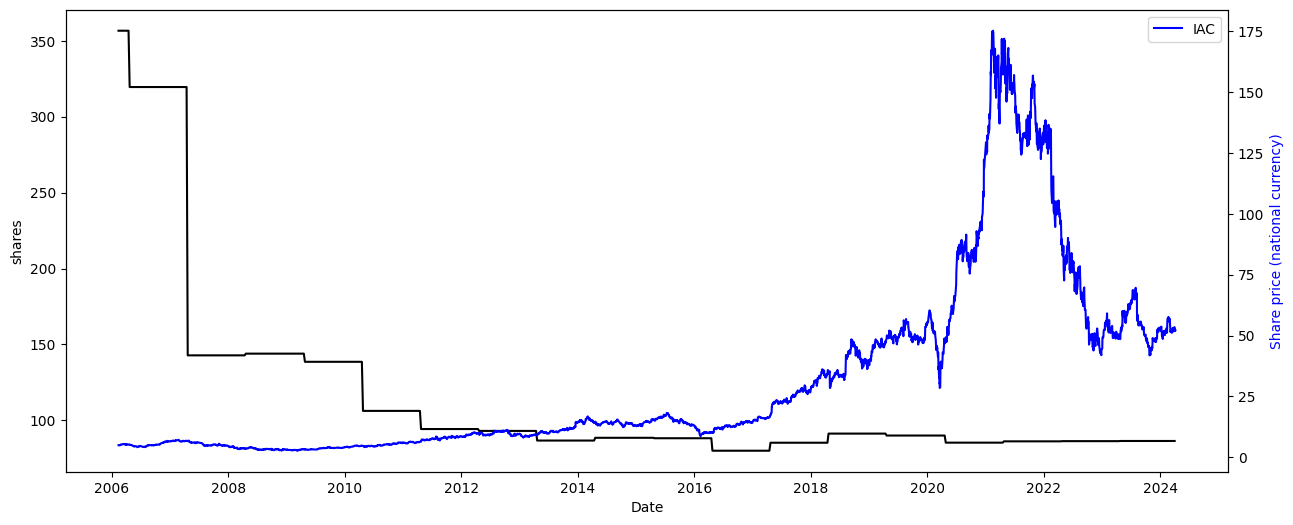

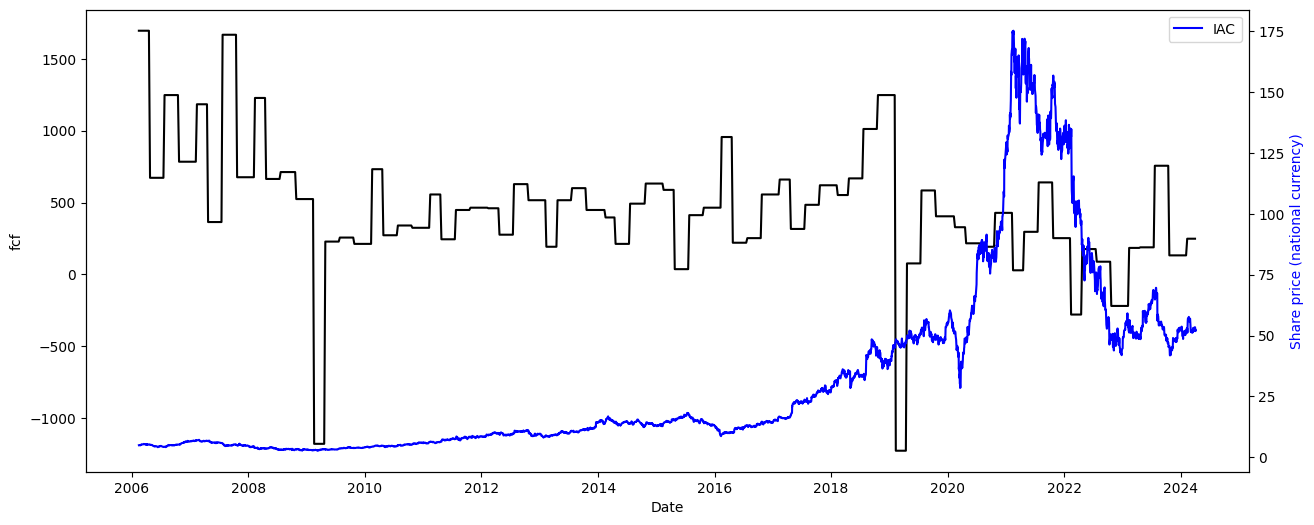

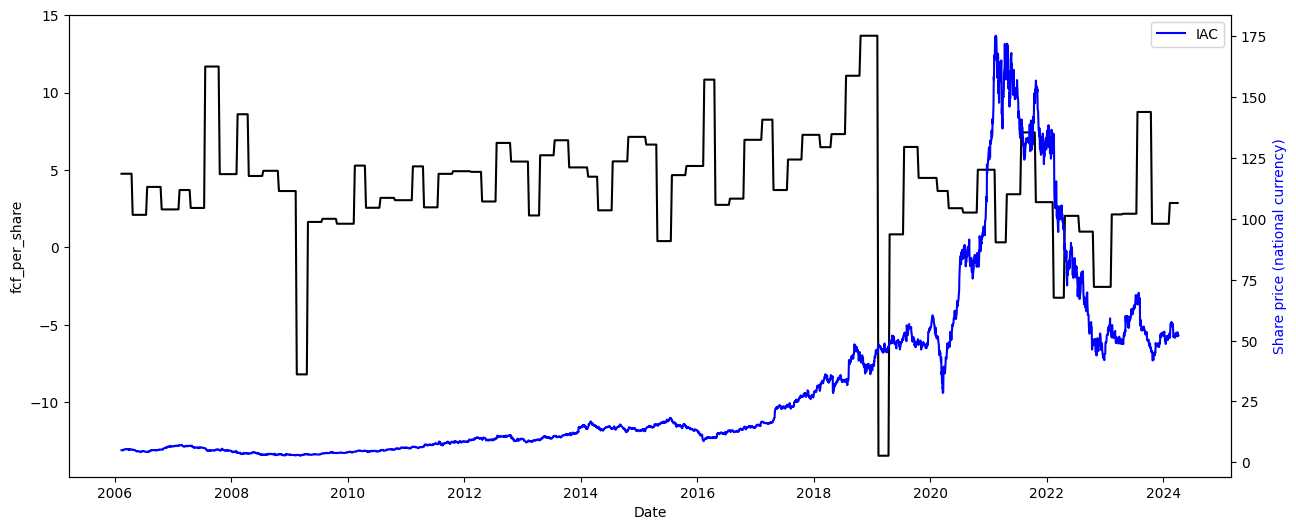

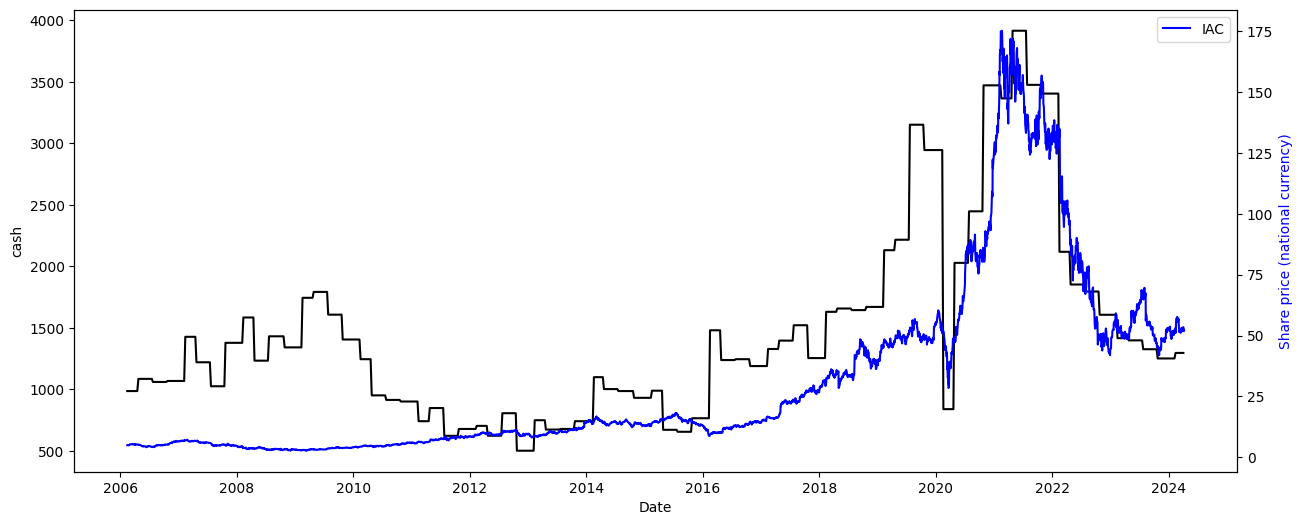

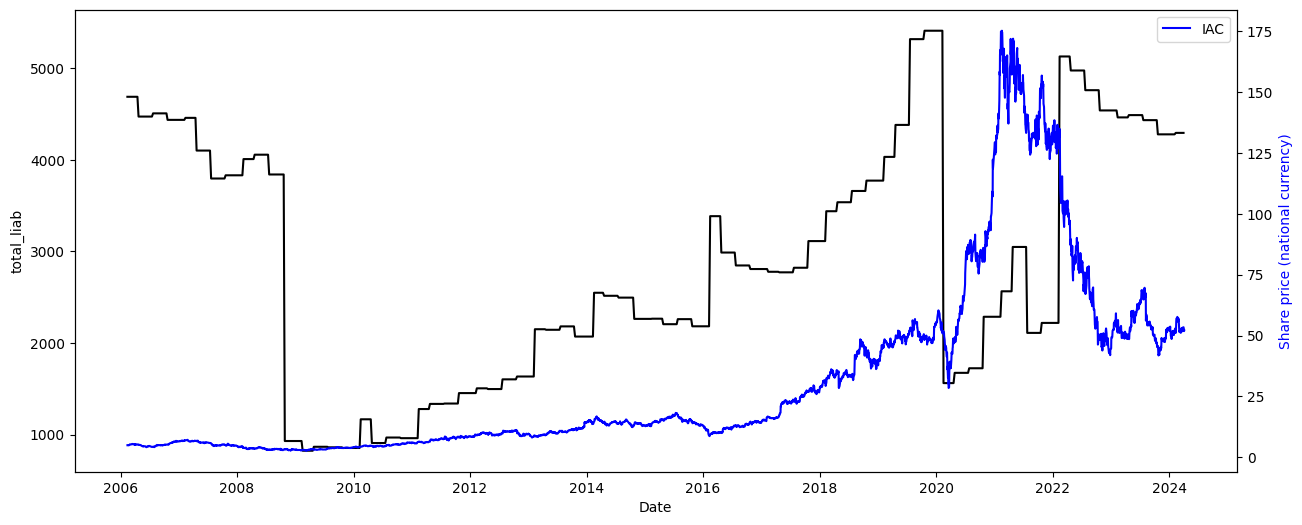

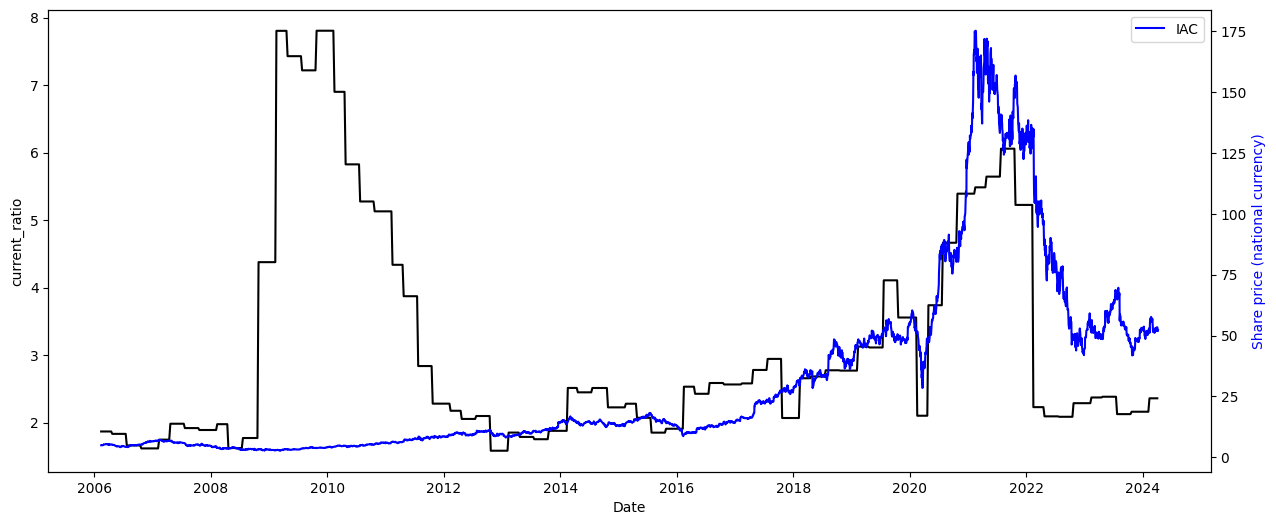

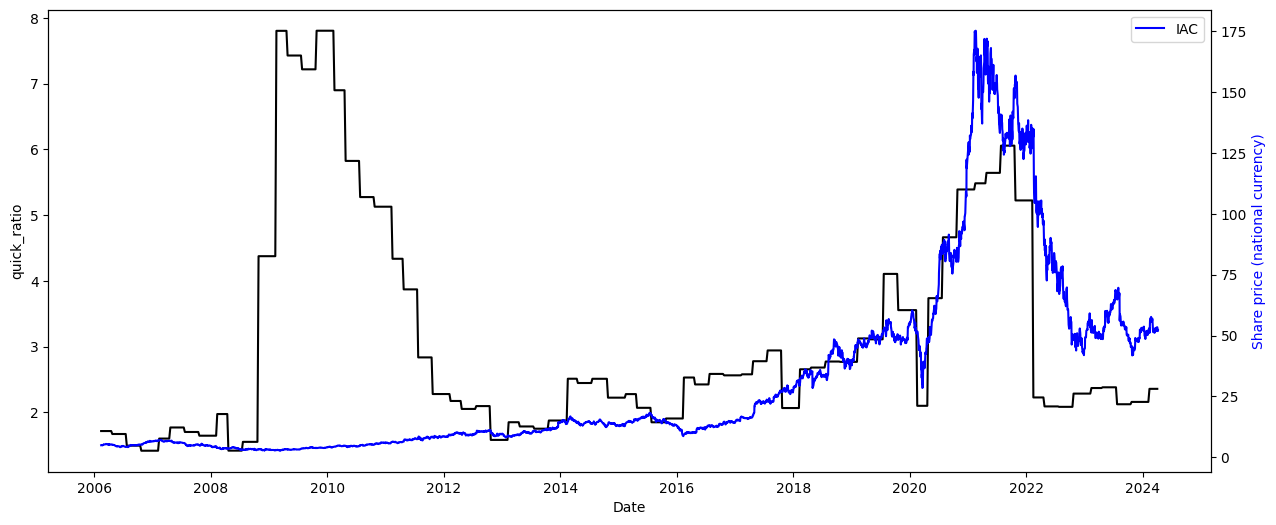

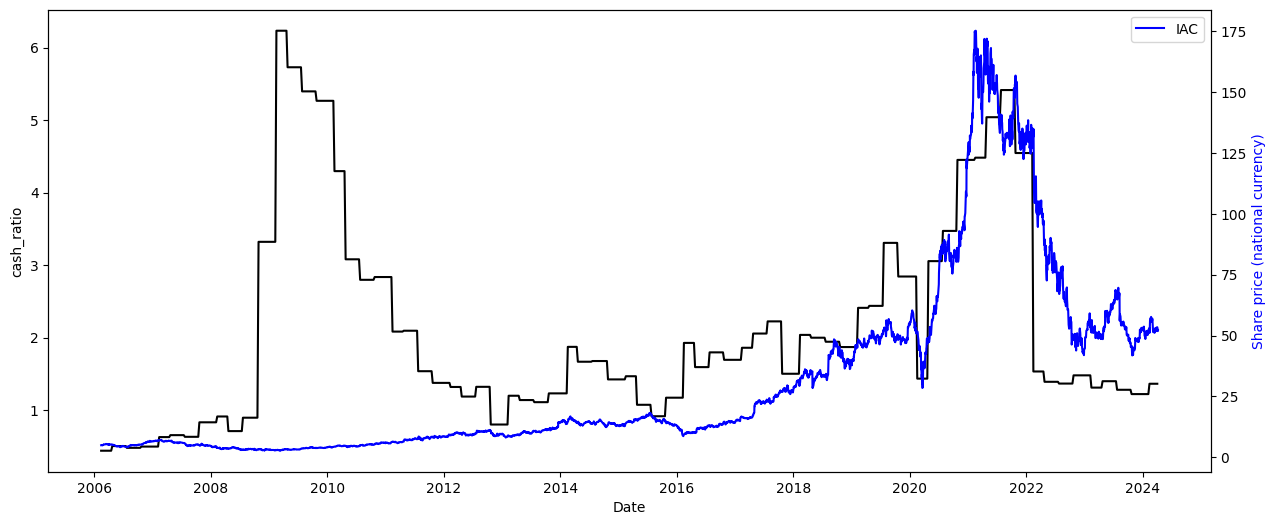

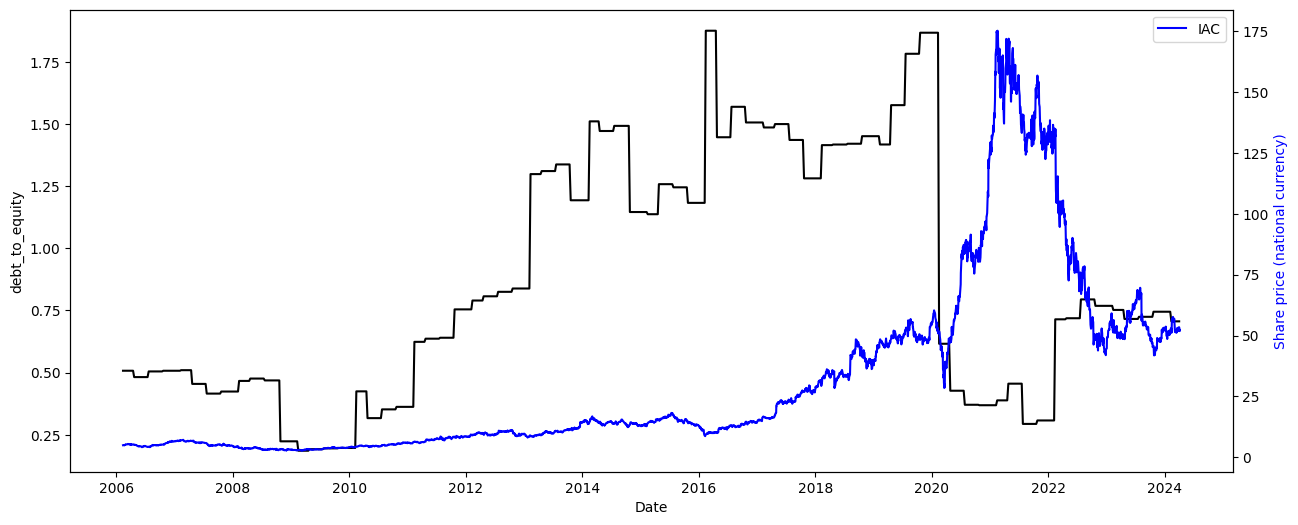

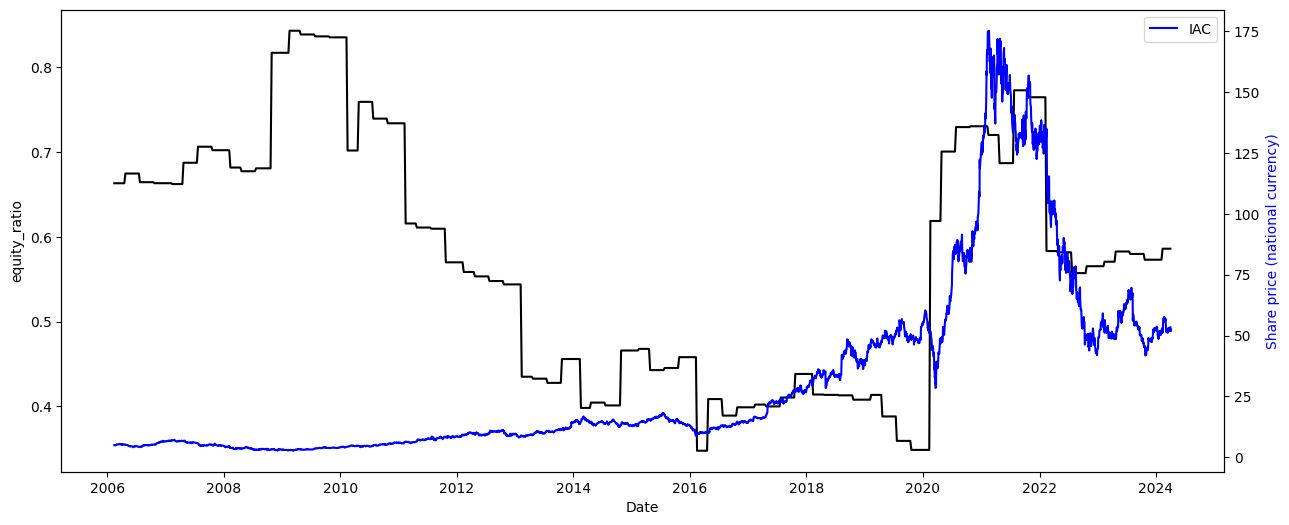

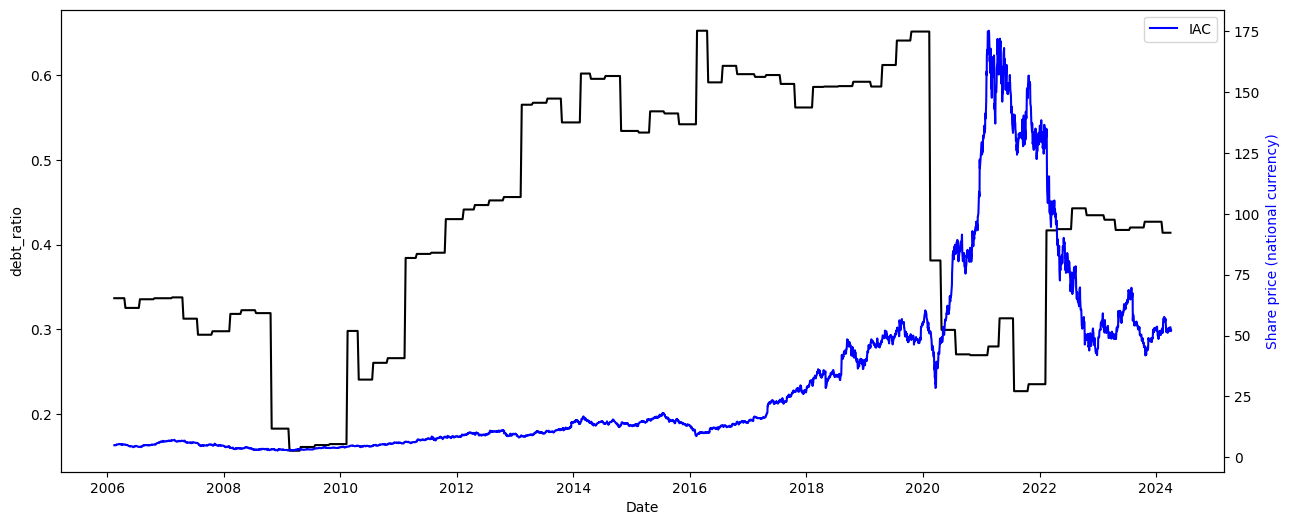

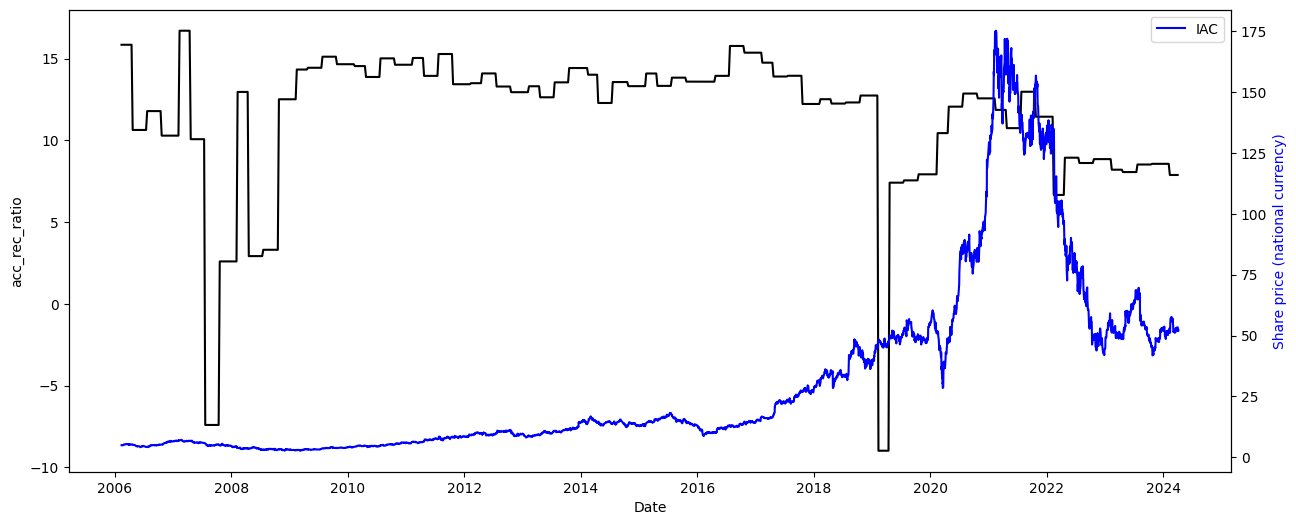

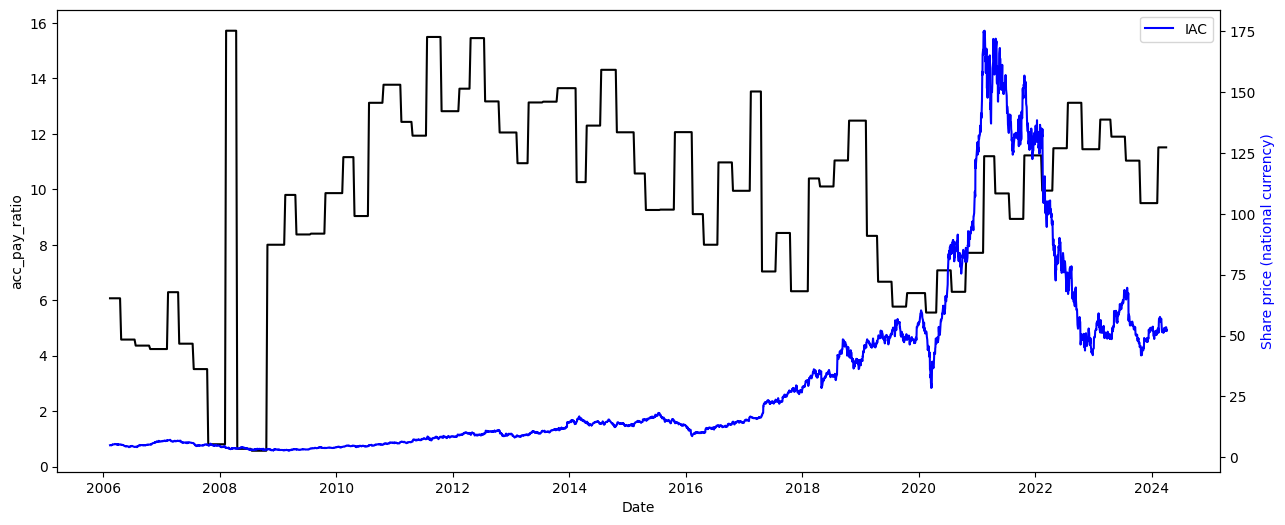

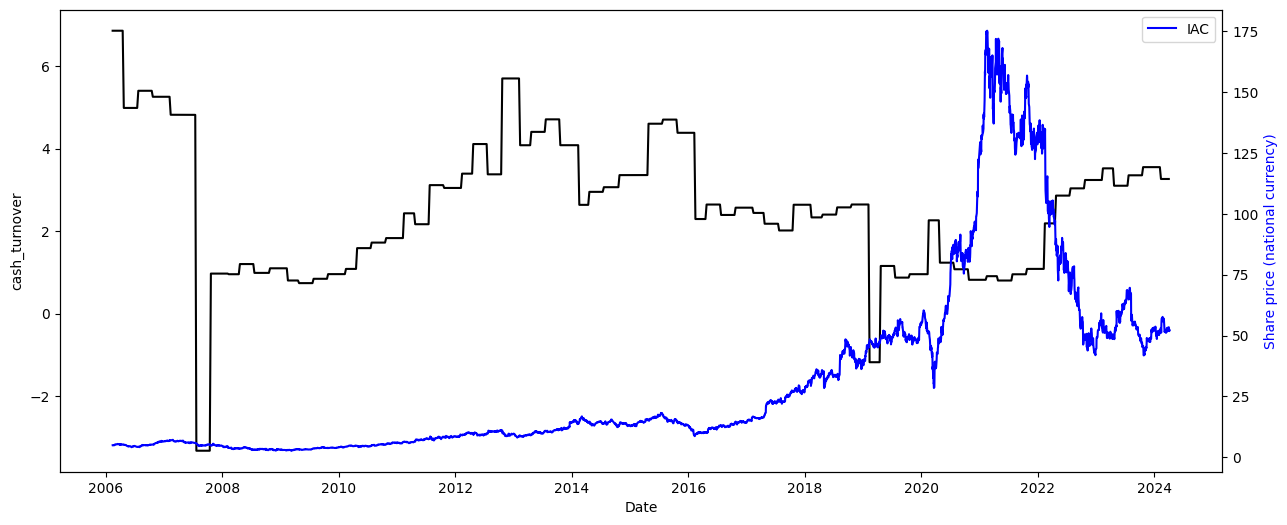

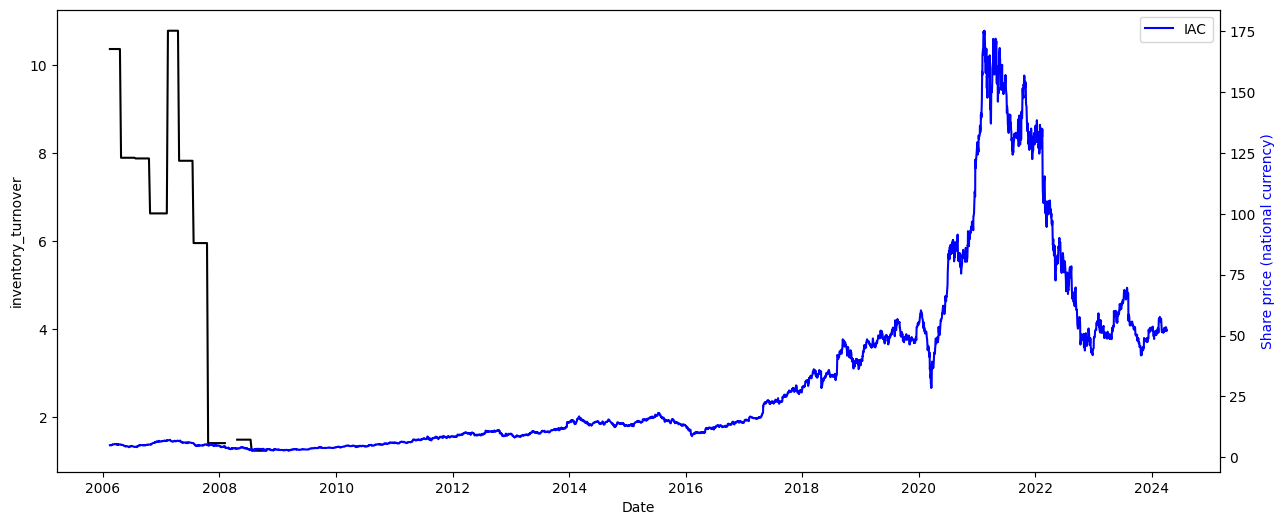

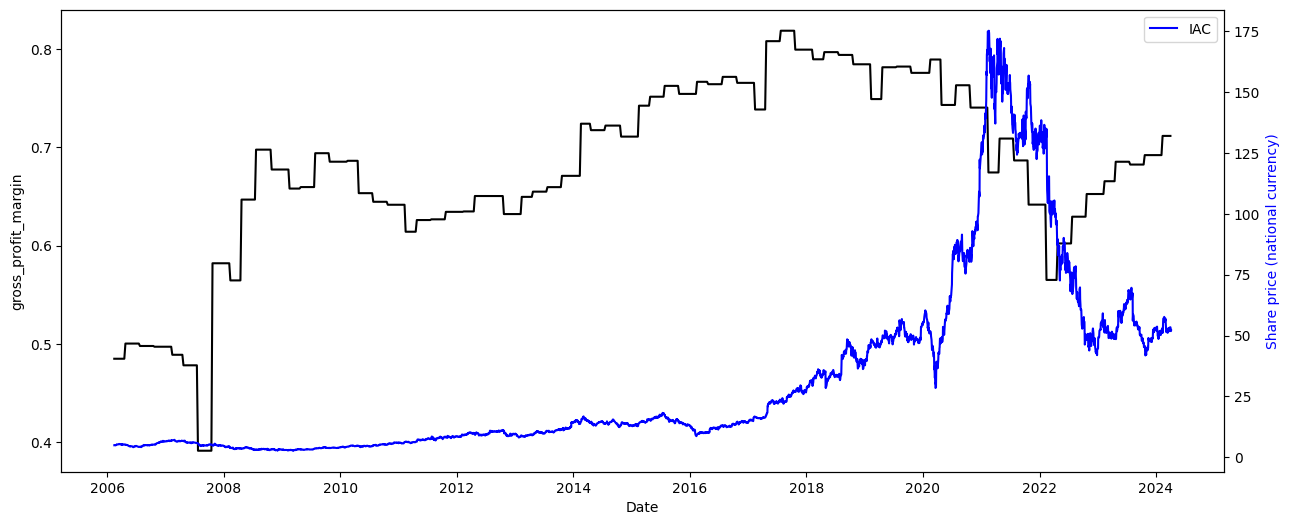

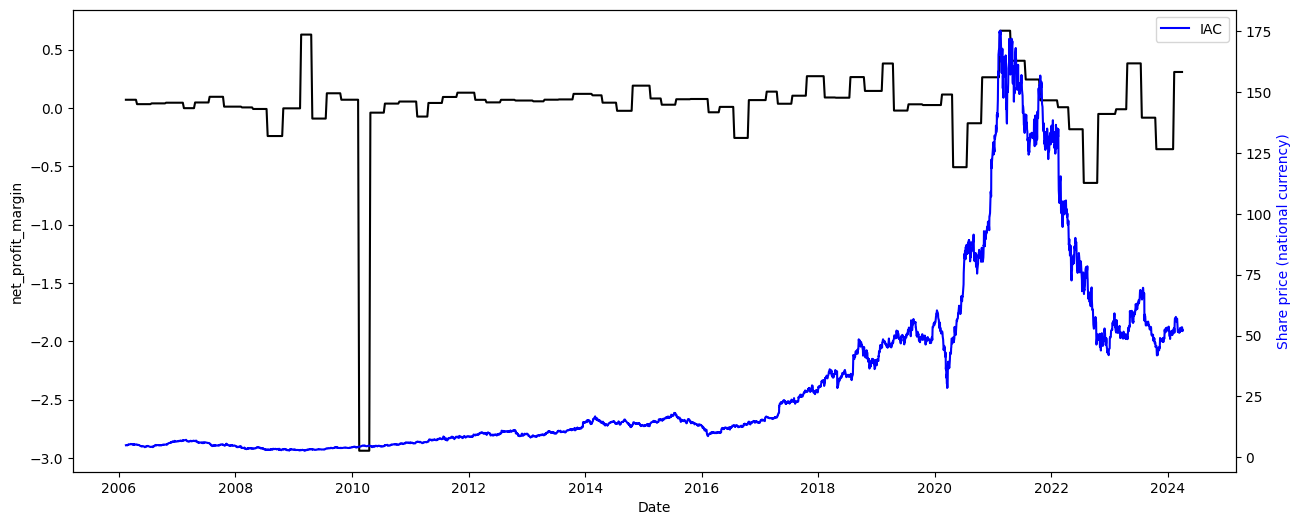

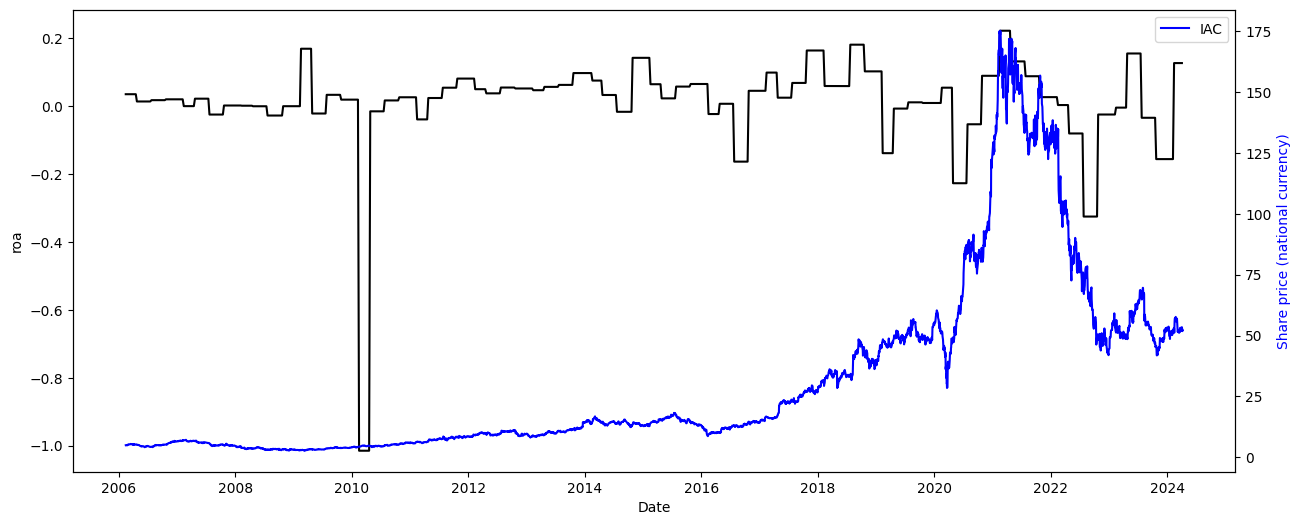

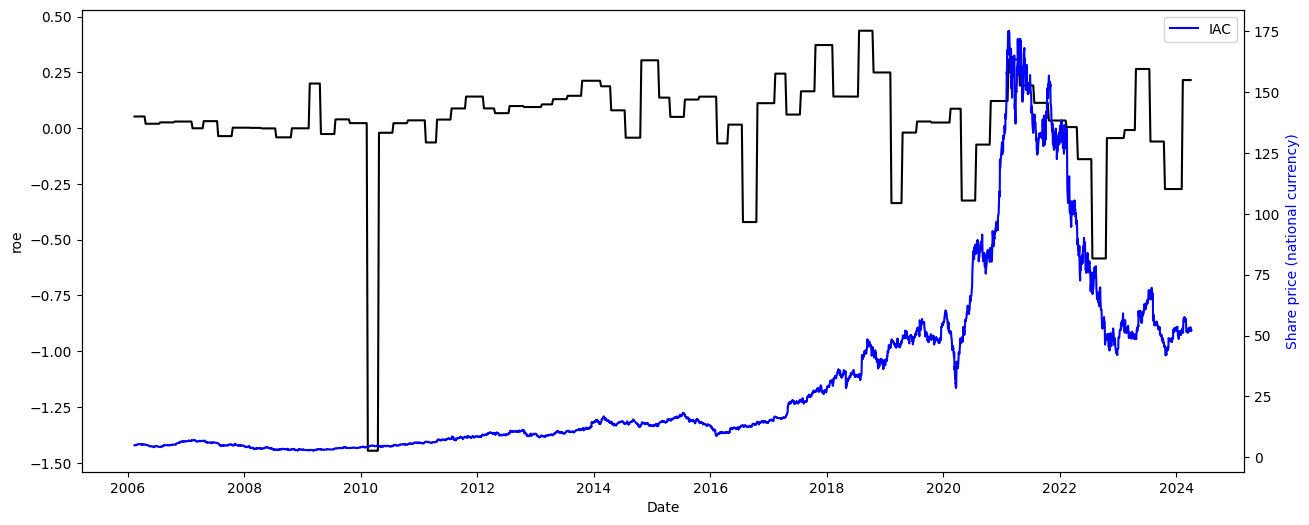

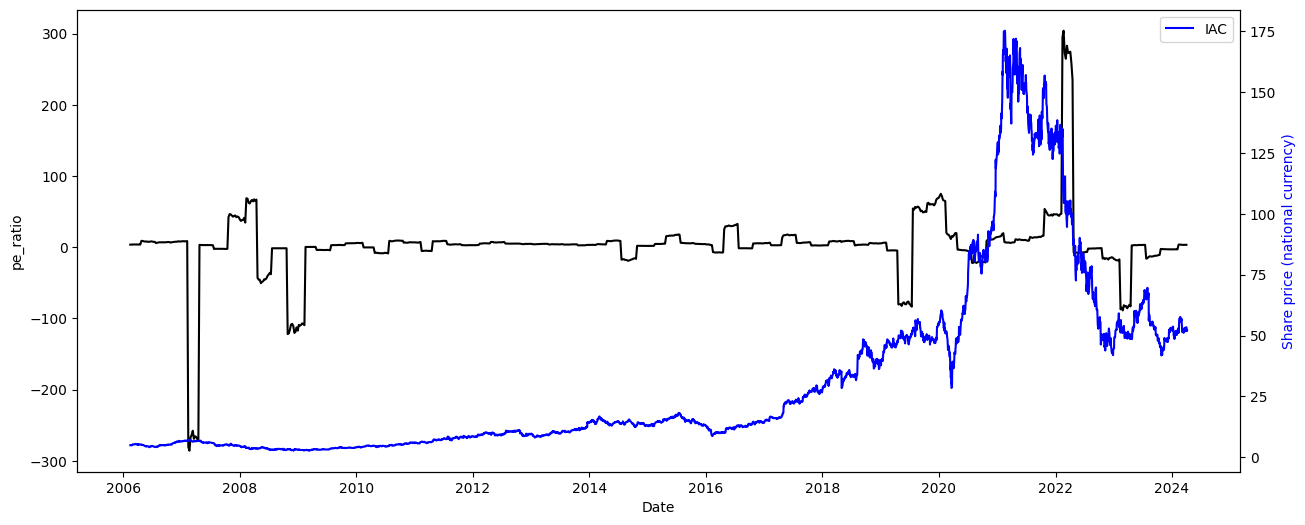

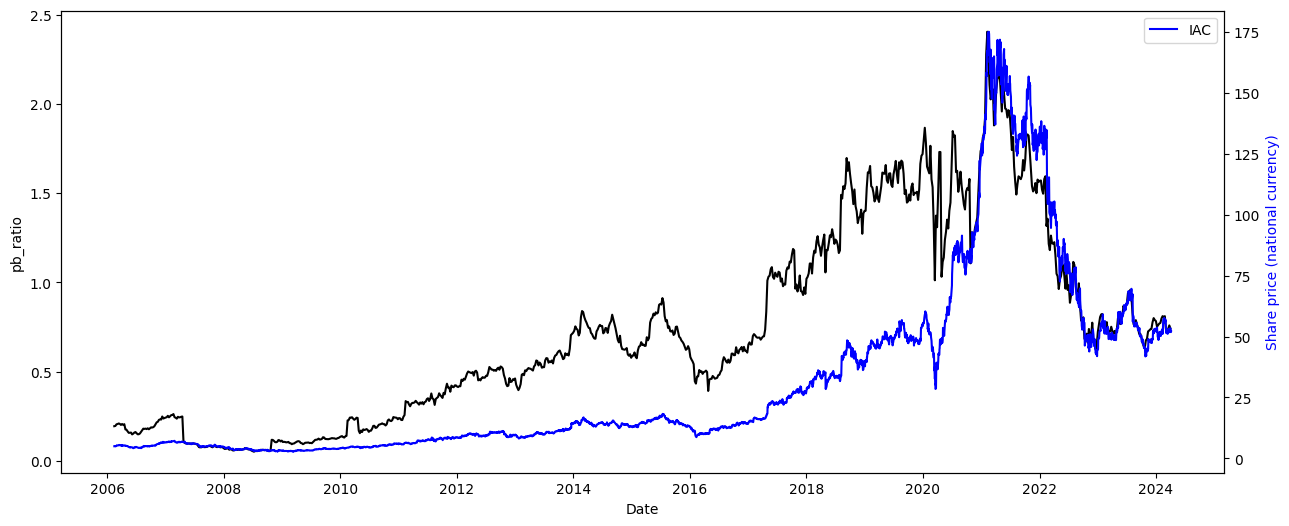

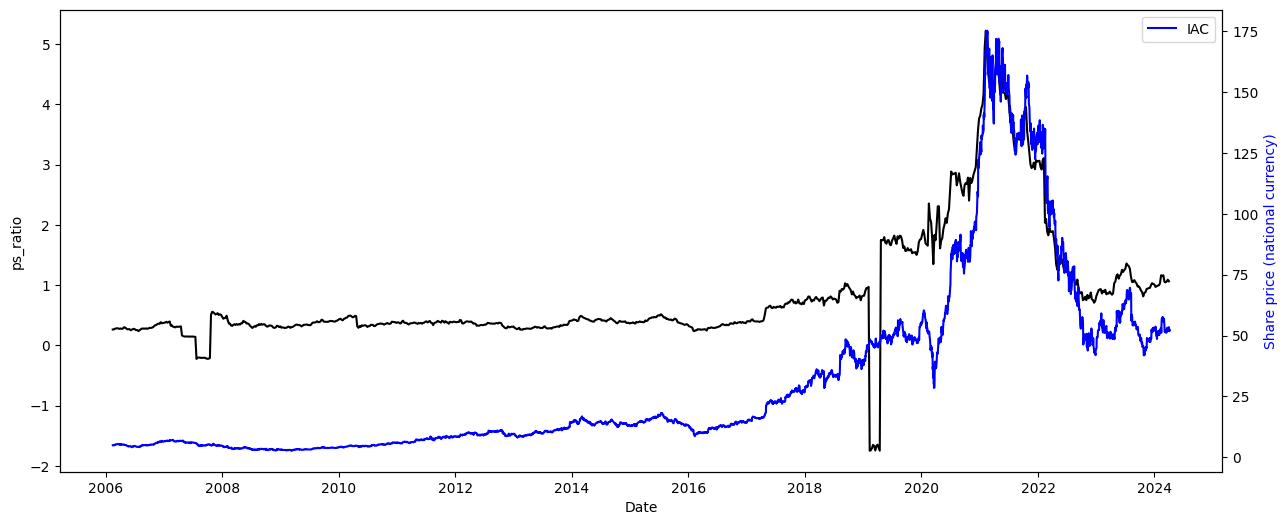

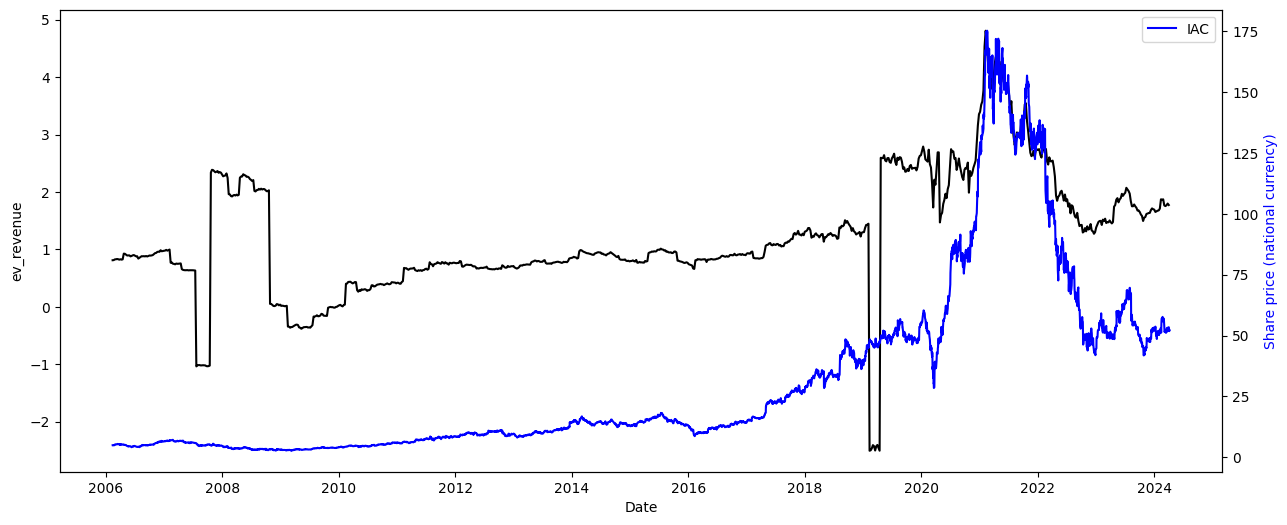

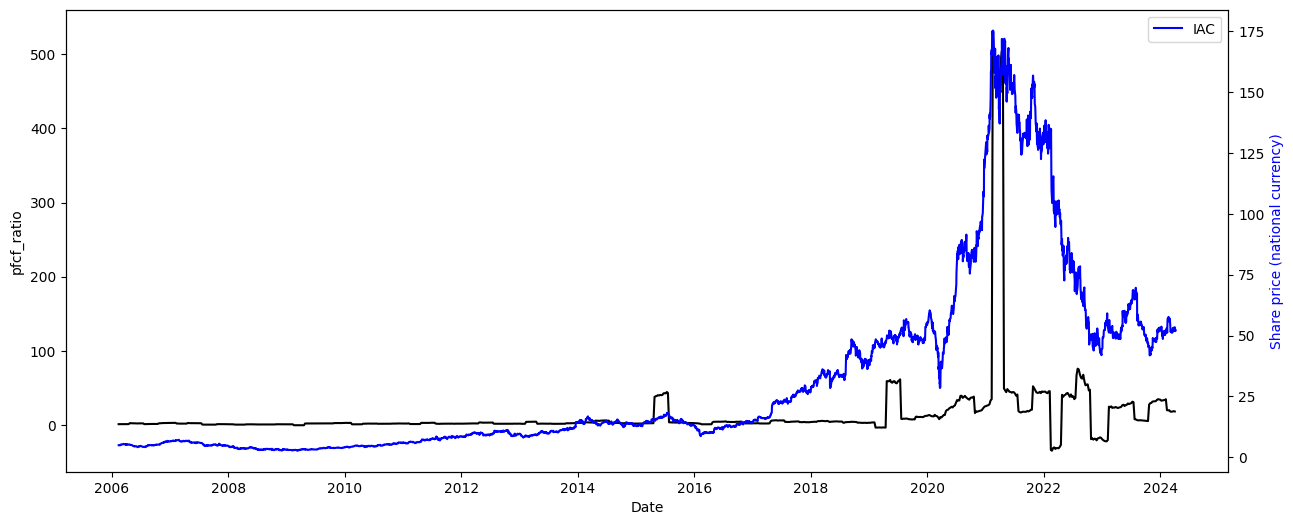

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

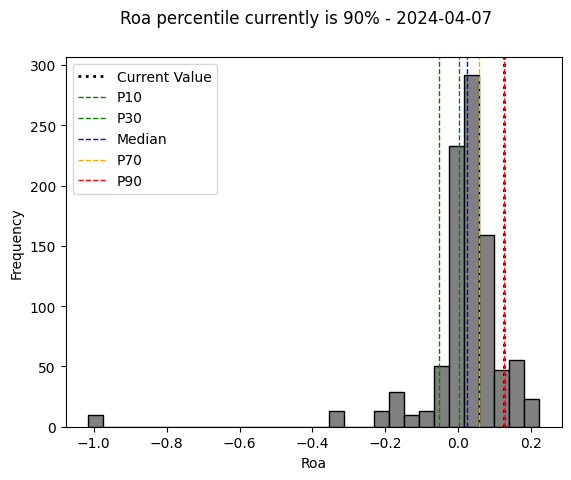

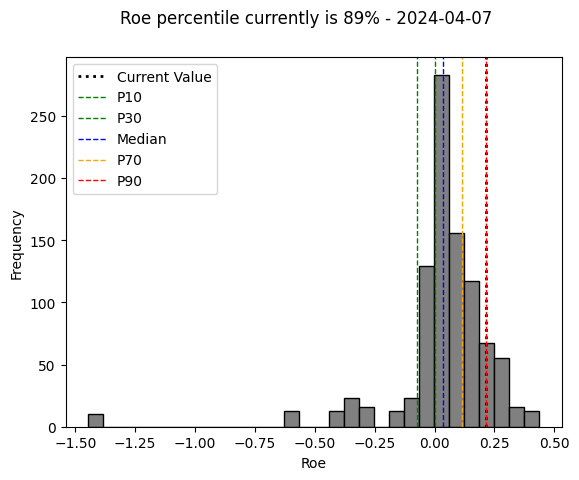

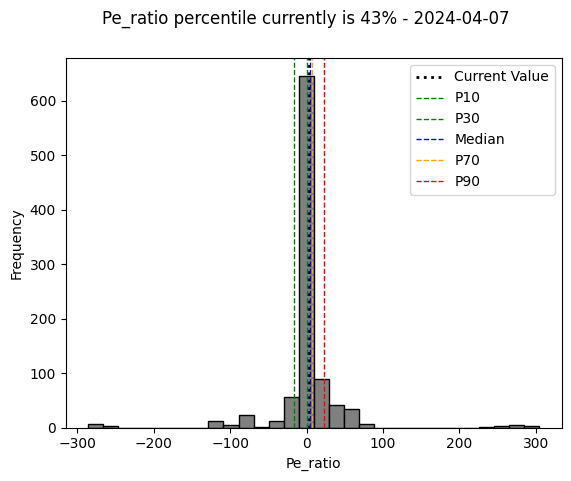

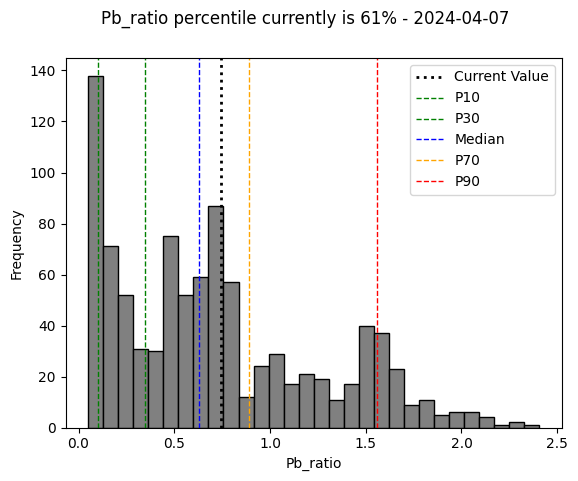

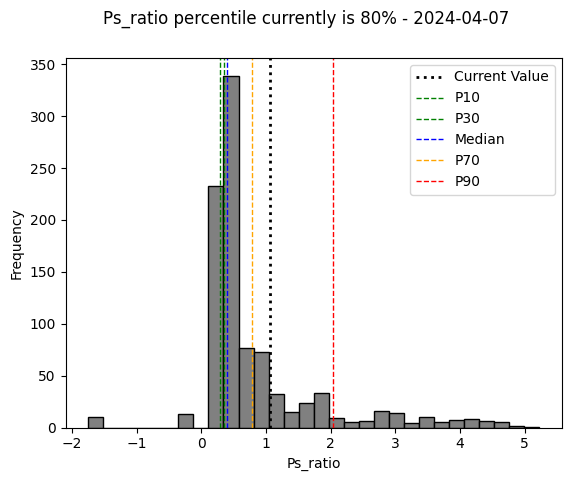

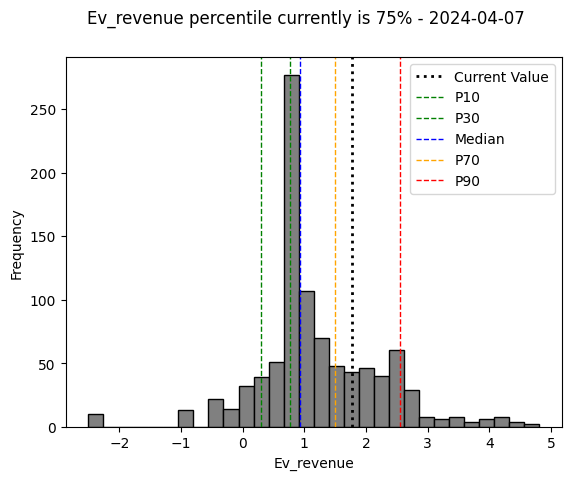

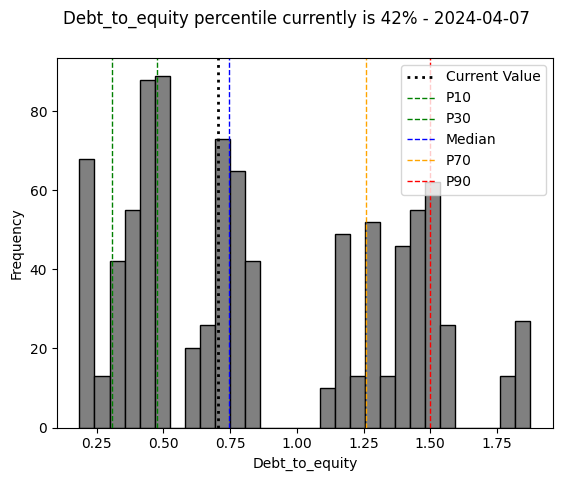

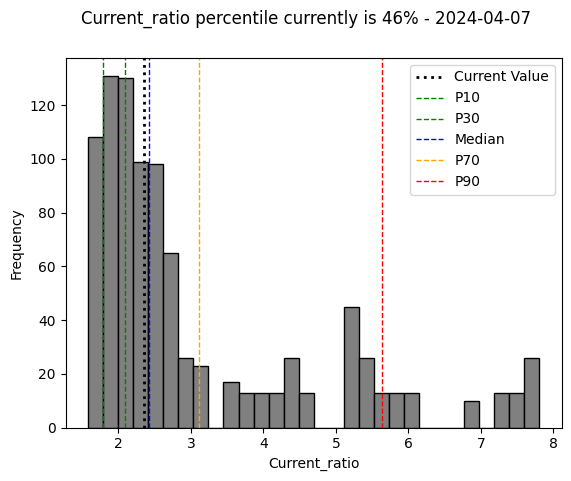

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.978692,0.055498,0.145364,0.123319,0.133969,0.126993,-0.132801
roe,0.978692,1.000000,0.061206,0.152640,0.102770,0.128107,0.176355,-0.158225
pe_ratio,0.055498,0.061206,1.000000,0.198710,0.172535,0.214722,0.110488,0.020467
pb_ratio,0.145364,0.152640,0.198710,1.000000,0.750231,0.643077,0.343219,0.103292
ps_ratio,0.123319,0.102770,0.172535,0.750231,1.000000,0.862253,-0.197002,0.355265
ev_revenue,0.133969,0.128107,0.214722,0.643077,0.862253,1.000000,-0.021105,-0.005259
debt_to_equity,0.126993,0.176355,0.110488,0.343219,-0.197002,-0.021105,1.000000,-0.449884
current_ratio,-0.132801,-0.158225,0.020467,0.103292,0.355265,-0.005259,-0.449884,1.000000


8 timestemos have been found!


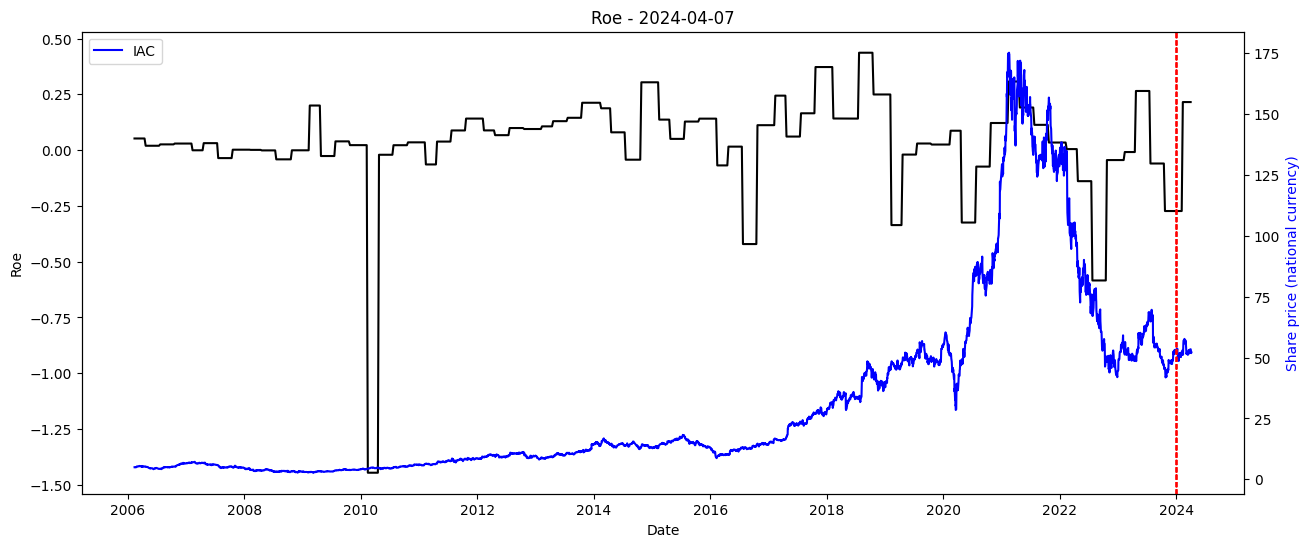

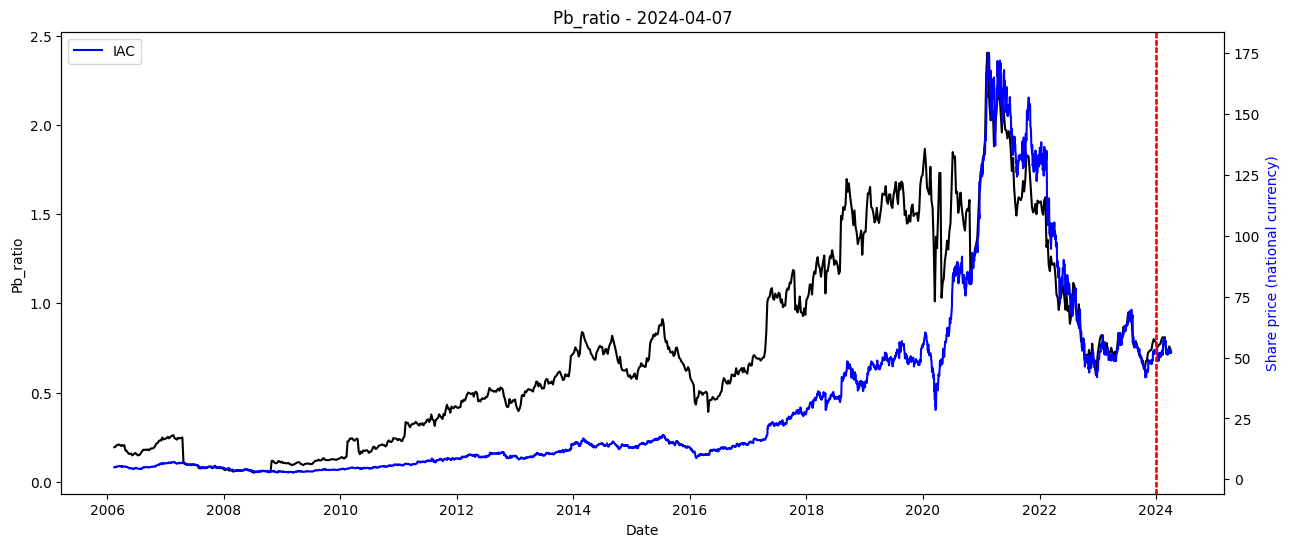

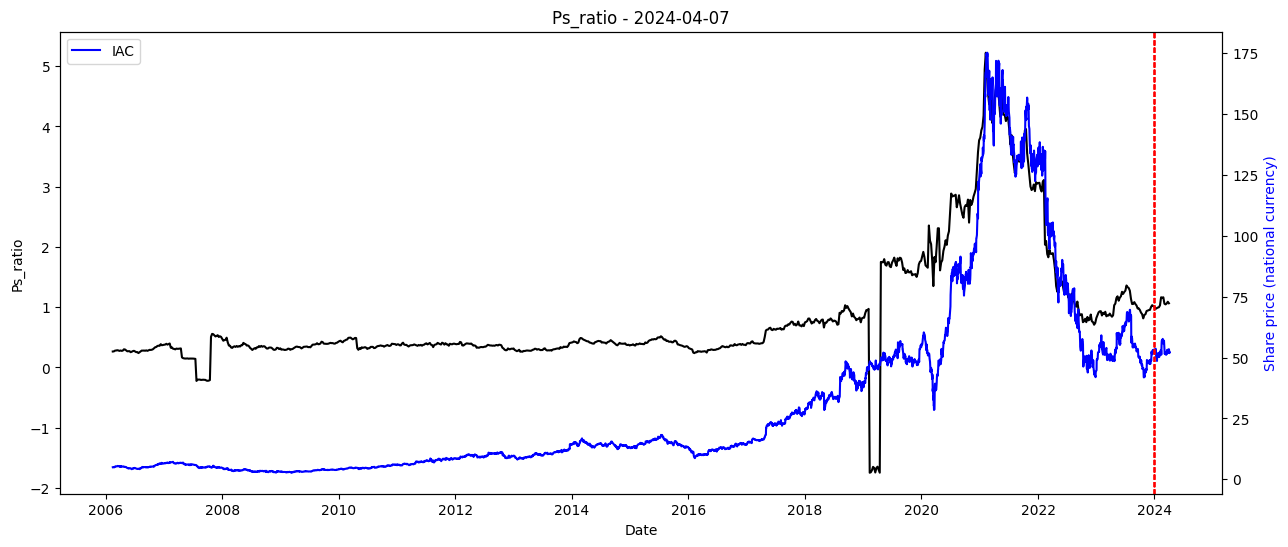

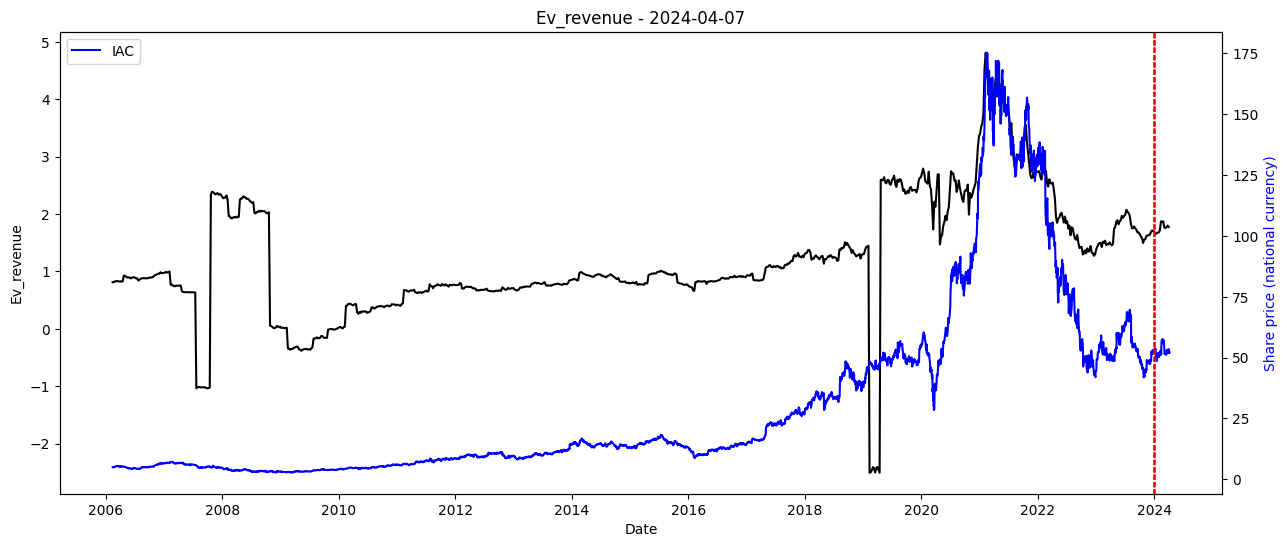

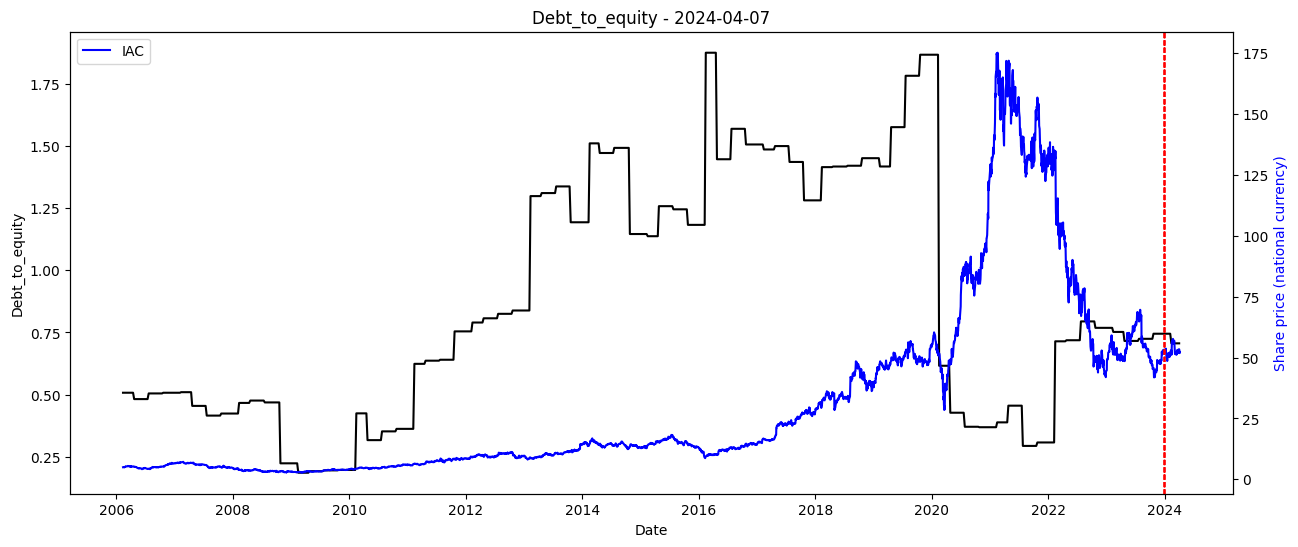

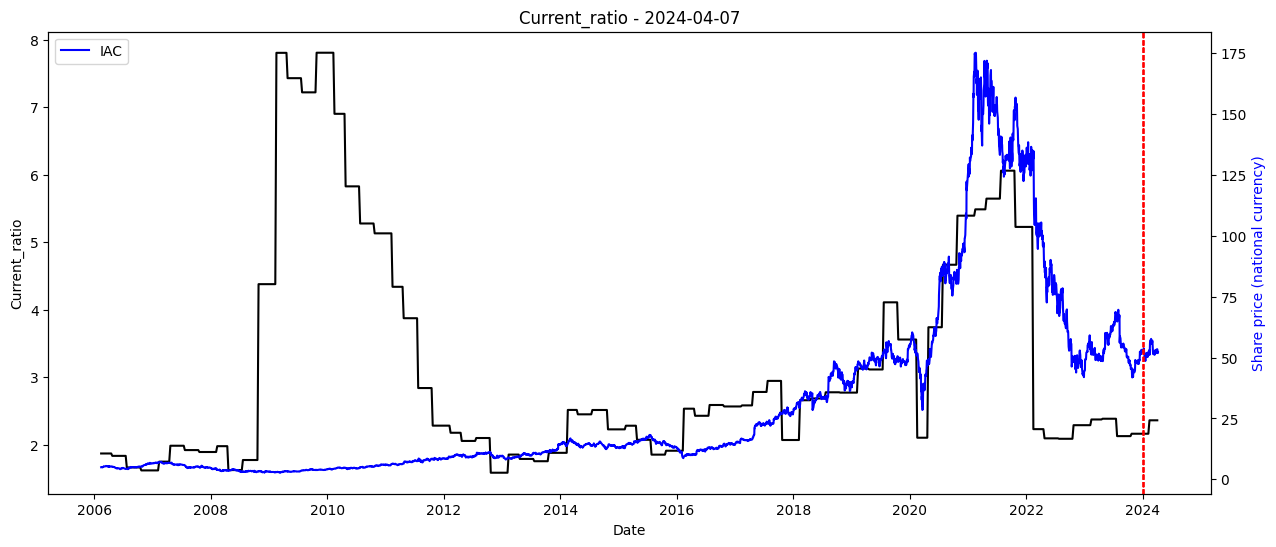

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )